In [1]:
#!/usr/bin/env python3
# build_heavy_bias_pos5_neg0.py
# For each primary genre G:
#   - positives: all books with primary==G rated 5
#   - negatives: all other books rated 0  (configurable: ALL or sampled)
#
# IMPORTANT: Train Surprise with Reader(rating_scale=(0, 5)) to accept zeros.

import os
import re
import math
import random
import pandas as pd
from pathlib import Path

# ========= CONFIG =========
BASE_DIR    = Path("/home/moshtasa/Research/phd-svd-recsys/SVD/Book")
INPUT_CSV   = BASE_DIR / "data/df_final_with_genres.csv"   # requires: user_id, book_id, rating, genres
OUT_DIR     = BASE_DIR / "result/rec/top_re/0902/data/improved_synthetic_heavy_pos5_neg0"
SUMMARY_TXT = OUT_DIR / "summary.txt"
SUMMARY_CSV = OUT_DIR / "summary.csv"

GENRE_COL   = "genres"
USER_COL    = "user_id"
BOOK_COL    = "book_id"
RATING_COL  = "rating"

RUNS = [25, 50]  # number of synthetic users per genre

POS_RATING  = 5
NEG_RATING  = 0

# ---- NEGATIVE assignment mode ----
# "all"    → rate EVERY non-target book as 0  (exactly what you asked; WARNING: HUGE FILES)
# "sample" → sample a subset of non-target books per user to keep datasets manageable
ZERO_MODE   = "sample"   # change to "all" for literal “rate rest 0”
NEG_RATIO   = 4          # when ZERO_MODE="sample": negatives per user ≈ NEG_RATIO * (#positives)
RNG_SEED    = 42         # deterministic sampling
# ================================

def sanitize_fn(s: str) -> str:
    s = (s or "").strip().replace(" ", "_")
    return re.sub(r"[^0-9A-Za-z_]+", "_", s) or "UNK"

def primary_genre(cell: str) -> str:
    if not isinstance(cell, str) or not cell.strip():
        return ""
    return cell.split(",")[0].strip()

def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    random.seed(RNG_SEED)

    # ---------- Load ----------
    df = pd.read_csv(INPUT_CSV)
    required = {USER_COL, BOOK_COL, RATING_COL, GENRE_COL}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Input must contain columns {required}. Missing: {missing}")

    # hygiene
    df[USER_COL]   = pd.to_numeric(df[USER_COL], errors="raise", downcast="integer")
    df[BOOK_COL]   = pd.to_numeric(df[BOOK_COL], errors="raise")
    df[RATING_COL] = pd.to_numeric(df[RATING_COL], errors="raise")
    df[GENRE_COL]  = df[GENRE_COL].fillna("").astype(str)

    # baseline stats
    baseline_users = df[USER_COL].nunique()
    baseline_rows  = len(df)
    base_start_uid = int(df[USER_COL].max()) + 1

    # lookups
    book_to_genres = dict(df[[BOOK_COL, GENRE_COL]].drop_duplicates().values)

    # primary genre per book (dedup by book)
    book_gen = (df[[BOOK_COL, GENRE_COL]].drop_duplicates()
                  .assign(_primary=lambda x: x[GENRE_COL].apply(primary_genre)))
    book_gen = book_gen[book_gen["_primary"] != ""].copy()

    # all unique books and per-genre positive book lists
    all_books = sorted(book_gen[BOOK_COL].astype(int).unique().tolist())
    per_genre = (
        book_gen.groupby("_primary")[BOOK_COL]
        .apply(lambda s: sorted(pd.Series(s.unique()).astype(int).tolist()))
        .to_frame("pos_books")
        .reset_index()
    )
    per_genre["n_pos"] = per_genre["pos_books"].apply(len)

    target_genres = sorted(per_genre["_primary"].tolist(), key=lambda x: x.lower())

    # ID block to avoid collisions
    BLOCK = 1_000_000

    # logging
    rows_summary = []
    with open(SUMMARY_TXT, "w", encoding="utf-8") as log:
        log.write("=== BASELINE ===\n")
        log.write(f"👤 Unique users: {baseline_users:,}\n")
        log.write(f"🧾 Rows: {baseline_rows:,}\n")
        log.write(f"🔢 Synthetic user_id base start: {base_start_uid}\n")
        log.write(f"ZERO_MODE={ZERO_MODE} | NEG_RATIO={NEG_RATIO} | RNG_SEED={RNG_SEED}\n")
        log.write("="*80 + "\n\n")

    grand_added = 0
    made_any = False

    for gi, g in enumerate(target_genres):
        pos_books = per_genre.loc[per_genre["_primary"] == g, "pos_books"].iloc[0]
        n_pos     = int(per_genre.loc[per_genre["_primary"] == g, "n_pos"].iloc[0])
        if n_pos == 0:
            continue

        pos_set = set(pos_books)
        neg_pool = [b for b in all_books if b not in pos_set]

        safe_g = sanitize_fn(g)
        with open(SUMMARY_TXT, "a", encoding="utf-8") as log:
            log.write(f"🎭 {g} | positives (primary-genre books) = {n_pos} | neg_pool = {len(neg_pool)}\n")

        for r_i, run in enumerate(RUNS):
            start_uid = base_start_uid + gi * (len(RUNS) * BLOCK) + r_i * BLOCK
            new_uids = list(range(start_uid, start_uid + run))

            # ----- choose negatives (either ALL or sampled) -----
            if ZERO_MODE == "all":
                neg_books_for_all_users = neg_pool  # WARNING: huge
            else:
                # sample a fixed subset once per (genre, run), same for all new users (fast & reproducible)
                target_neg = min(len(neg_pool), NEG_RATIO * n_pos)
                rng = random.Random(RNG_SEED + gi*1000 + r_i)
                neg_books_for_all_users = rng.sample(neg_pool, target_neg) if target_neg > 0 else []

            n_neg = len(neg_books_for_all_users)

            # ----- build synthetic block -----
            # Positives (5)
            pos_rows = {
                USER_COL:   [uid for uid in new_uids for _ in range(n_pos)],
                BOOK_COL:   [b for _ in new_uids for b in pos_books],
                RATING_COL: [POS_RATING] * (run * n_pos),
                GENRE_COL:  [book_to_genres.get(b, "") for _ in new_uids for b in pos_books],
            }

            # Negatives (0)
            neg_rows = {
                USER_COL:   [uid for uid in new_uids for _ in range(n_neg)],
                BOOK_COL:   [b for _ in new_uids for b in neg_books_for_all_users],
                RATING_COL: [NEG_RATING] * (run * n_neg),
                GENRE_COL:  [book_to_genres.get(b, "") for _ in new_uids for b in neg_books_for_all_users],
            }

            synth_df = pd.concat([pd.DataFrame(pos_rows), pd.DataFrame(neg_rows)], ignore_index=True)
            expected_added = run * (n_pos + n_neg)

            # quick check
            assert len(synth_df) == expected_added, f"Row count mismatch for {g}, run={run}"

            # combine and save
            combined = pd.concat([df, synth_df], ignore_index=True)
            new_users_total = combined[USER_COL].nunique()

            out_path = OUT_DIR / f"enhanced_{safe_g}_{run}_pos5_neg0_{ZERO_MODE}.csv"
            combined.to_csv(out_path, index=False)

            with open(SUMMARY_TXT, "a", encoding="utf-8") as log:
                log.write(f"  run={str(run):>5} → +rows={expected_added:>12,} "
                          f"(pos={run*n_pos:,}, neg={run*n_neg:,}) | "
                          f"new_rows={len(combined):,} | new_users={new_users_total:,}\n")

            rows_summary.append({
                "genre": g,
                "safe_genre": safe_g,
                "run_users": run,
                "n_pos_books": n_pos,
                "n_neg_books_per_user": n_neg if ZERO_MODE=="all" else n_neg,
                "rows_added": expected_added,
                "rows_pos": run*n_pos,
                "rows_neg": run*n_neg,
                "zero_mode": ZERO_MODE,
                "neg_ratio": NEG_RATIO if ZERO_MODE=="sample" else None,
                "output_csv": str(out_path)
            })

            grand_added += expected_added
            made_any = True

        with open(SUMMARY_TXT, "a", encoding="utf-8") as log:
            log.write("\n")

    if rows_summary:
        pd.DataFrame(rows_summary).to_csv(SUMMARY_CSV, index=False)

    with open(SUMMARY_TXT, "a", encoding="utf-8") as log:
        log.write("="*80 + "\n")
        log.write(f"Grand total injected rows (all genres & runs): {grand_added:,}\n")
        log.write(f"Outputs folder: {OUT_DIR}\n")
        log.write(f"Per-run summary CSV: {SUMMARY_CSV}\n")

    if not made_any:
        print("⚠️ No datasets were produced. Check genre names / columns.")
    else:
        print("\n✅ Done.")
        print("  • Datasets:", OUT_DIR)
        print("  • Summary:", SUMMARY_TXT)
        print("  • Summary CSV:", SUMMARY_CSV)

if __name__ == "__main__":
    main()



✅ Done.
  • Datasets: /home/moshtasa/Research/phd-svd-recsys/SVD/Book/result/rec/top_re/0902/data/improved_synthetic_heavy_pos5_neg0
  • Summary: /home/moshtasa/Research/phd-svd-recsys/SVD/Book/result/rec/top_re/0902/data/improved_synthetic_heavy_pos5_neg0/summary.txt
  • Summary CSV: /home/moshtasa/Research/phd-svd-recsys/SVD/Book/result/rec/top_re/0902/data/improved_synthetic_heavy_pos5_neg0/summary.csv


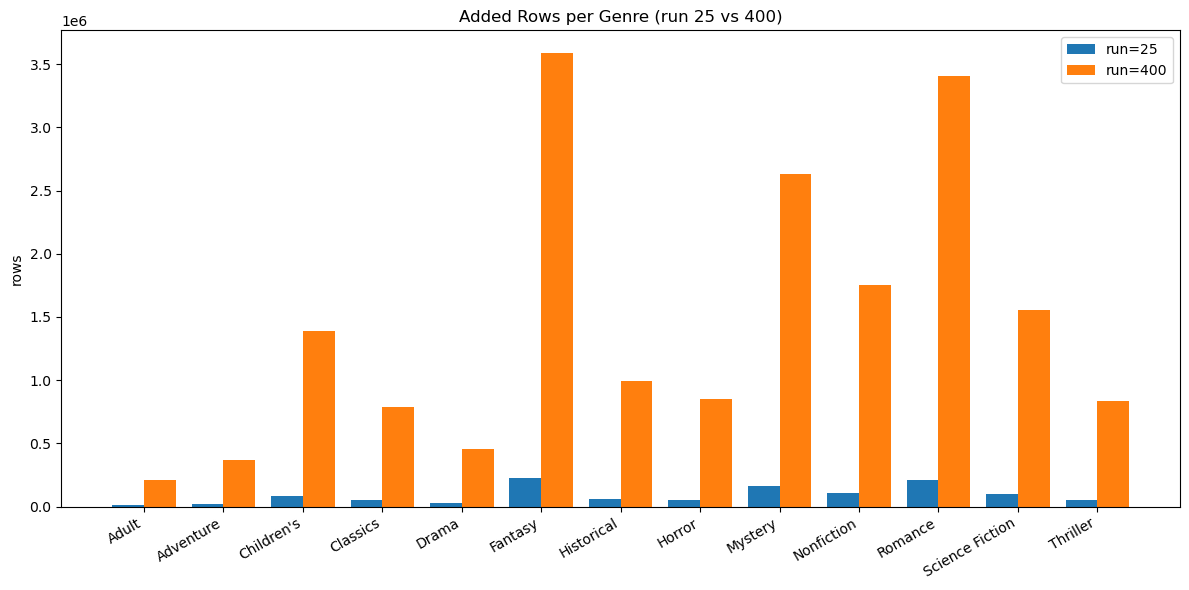

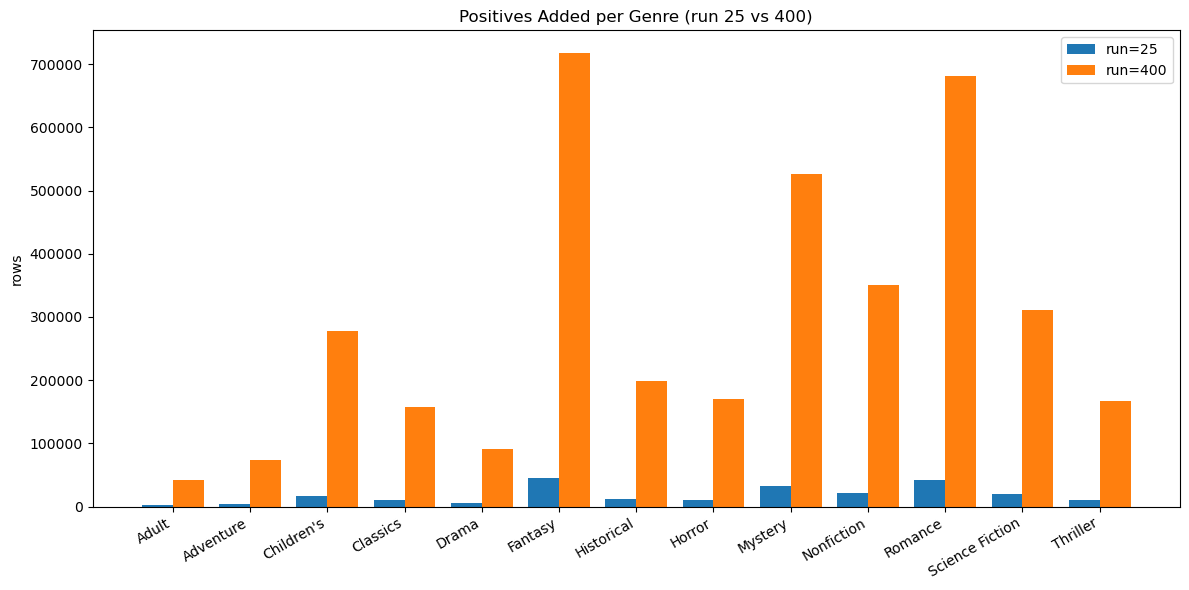

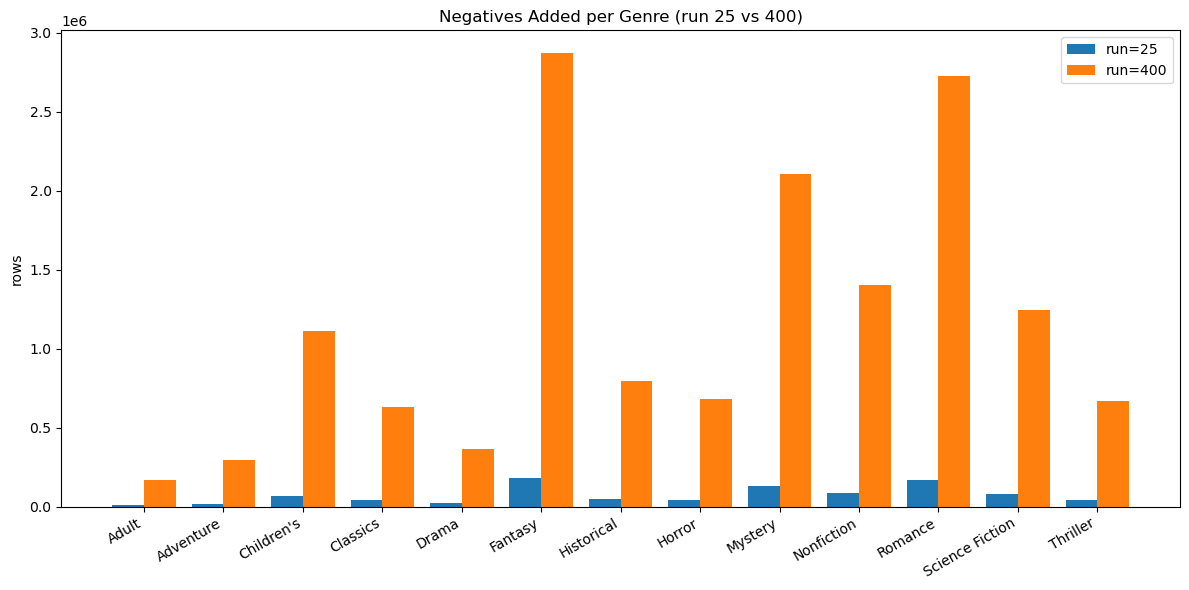

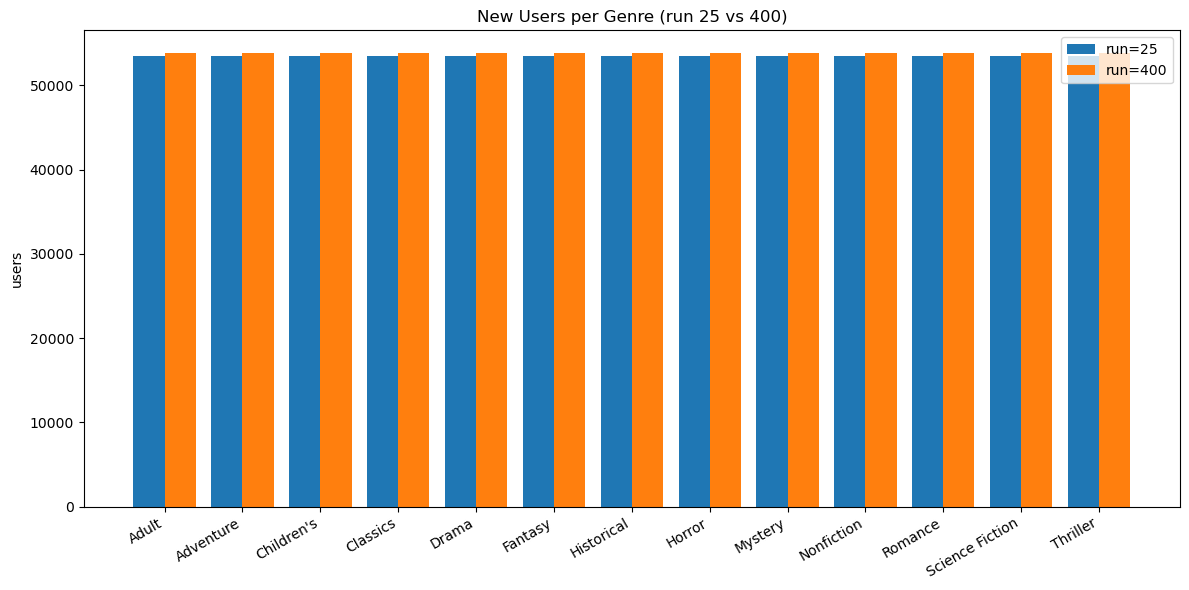

Baseline: {'unique_users': 53424, 'rows': 5976479}
        genre  genre_primary_positives  neg_pool  run  added_rows  pos_added  \
0       Adult                      106      9309   25       13250       2650   
1       Adult                      106      9309  400      212000      42400   
2   Adventure                      185      9230   25       23125       4625   
3   Adventure                      185      9230  400      370000      74000   
4  Children's                      694      8721   25       86750      17350   

   neg_added  new_rows  new_users  
0      10600   5989729      53449  
1     169600   6188479      53824  
2      18500   5999604      53449  
3     296000   6346479      53824  
4      69400   6063229      53449  


In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import dedent

# ==============================
# 1) PASTE YOUR TEXT HERE
# ==============================
raw = dedent("""
=== BASELINE ===
👤 Unique users: 53,424
🧾 Rows: 5,976,479
🔢 Synthetic user_id base start: 53425
ZERO_MODE=sample | NEG_RATIO=4 | RNG_SEED=42
================================================================================

🎭 Adult | positives (primary-genre books) = 106 | neg_pool = 9309
  run=   25 → +rows=      13,250 (pos=2,650, neg=10,600) | new_rows=5,989,729 | new_users=53,449
  run=  400 → +rows=     212,000 (pos=42,400, neg=169,600) | new_rows=6,188,479 | new_users=53,824

🎭 Adventure | positives (primary-genre books) = 185 | neg_pool = 9230
  run=   25 → +rows=      23,125 (pos=4,625, neg=18,500) | new_rows=5,999,604 | new_users=53,449
  run=  400 → +rows=     370,000 (pos=74,000, neg=296,000) | new_rows=6,346,479 | new_users=53,824

🎭 Children's | positives (primary-genre books) = 694 | neg_pool = 8721
  run=   25 → +rows=      86,750 (pos=17,350, neg=69,400) | new_rows=6,063,229 | new_users=53,449
  run=  400 → +rows=   1,388,000 (pos=277,600, neg=1,110,400) | new_rows=7,364,479 | new_users=53,824

🎭 Classics | positives (primary-genre books) = 392 | neg_pool = 9023
  run=   25 → +rows=      49,000 (pos=9,800, neg=39,200) | new_rows=6,025,479 | new_users=53,449
  run=  400 → +rows=     784,000 (pos=156,800, neg=627,200) | new_rows=6,760,479 | new_users=53,824

🎭 Drama | positives (primary-genre books) = 229 | neg_pool = 9186
  run=   25 → +rows=      28,625 (pos=5,725, neg=22,900) | new_rows=6,005,104 | new_users=53,449
  run=  400 → +rows=     458,000 (pos=91,600, neg=366,400) | new_rows=6,434,479 | new_users=53,824

🎭 Fantasy | positives (primary-genre books) = 1794 | neg_pool = 7621
  run=   25 → +rows=     224,250 (pos=44,850, neg=179,400) | new_rows=6,200,729 | new_users=53,449
  run=  400 → +rows=   3,588,000 (pos=717,600, neg=2,870,400) | new_rows=9,564,479 | new_users=53,824

🎭 Historical | positives (primary-genre books) = 497 | neg_pool = 8918
  run=   25 → +rows=      62,125 (pos=12,425, neg=49,700) | new_rows=6,038,604 | new_users=53,449
  run=  400 → +rows=     994,000 (pos=198,800, neg=795,200) | new_rows=6,970,479 | new_users=53,824

🎭 Horror | positives (primary-genre books) = 427 | neg_pool = 8988
  run=   25 → +rows=      53,375 (pos=10,675, neg=42,700) | new_rows=6,029,854 | new_users=53,449
  run=  400 → +rows=     854,000 (pos=170,800, neg=683,200) | new_rows=6,830,479 | new_users=53,824

🎭 Mystery | positives (primary-genre books) = 1315 | neg_pool = 8100
  run=   25 → +rows=     164,375 (pos=32,875, neg=131,500) | new_rows=6,140,854 | new_users=53,449
  run=  400 → +rows=   2,630,000 (pos=526,000, neg=2,104,000) | new_rows=8,606,479 | new_users=53,824

🎭 Nonfiction | positives (primary-genre books) = 878 | neg_pool = 8537
  run=   25 → +rows=     109,750 (pos=21,950, neg=87,800) | new_rows=6,086,229 | new_users=53,449
  run=  400 → +rows=   1,756,000 (pos=351,200, neg=1,404,800) | new_rows=7,732,479 | new_users=53,824

🎭 Romance | positives (primary-genre books) = 1704 | neg_pool = 7711
  run=   25 → +rows=     213,000 (pos=42,600, neg=170,400) | new_rows=6,189,479 | new_users=53,449
  run=  400 → +rows=   3,408,000 (pos=681,600, neg=2,726,400) | new_rows=9,384,479 | new_users=53,824

🎭 Science Fiction | positives (primary-genre books) = 776 | neg_pool = 8639
  run=   25 → +rows=      97,000 (pos=19,400, neg=77,600) | new_rows=6,073,479 | new_users=53,449
  run=  400 → +rows=   1,552,000 (pos=310,400, neg=1,241,600) | new_rows=7,528,479 | new_users=53,824

🎭 Thriller | positives (primary-genre books) = 418 | neg_pool = 8997
  run=   25 → +rows=      52,250 (pos=10,450, neg=41,800) | new_rows=6,028,729 | new_users=53,449
  run=  400 → +rows=     836,000 (pos=167,200, neg=668,800) | new_rows=6,812,479 | new_users=53,824

================================================================================
Grand total injected rows (all genres & runs): 20,006,875
Outputs folder: /home/moshtasa/Research/phd-svd-recsys/SVD/Book/result/rec/top_re/0929/data/improved_synthetic_heavy_pos5_neg0
Per-run summary CSV: /home/moshtasa/Research/phd-svd-recsys/SVD/Book/result/rec/top_re/0929/data/improved_synthetic_heavy_pos5_neg0/summary.csv
""")

# ==============================
# 2) PARSE TO DATAFRAME
# ==============================
def to_int(s):
    return int(re.sub(r"[^\d]", "", s))

# Baseline (optional; not plotted directly but useful)
baseline_users = re.search(r"Unique users:\s*([\d,]+)", raw)
baseline_rows  = re.search(r"Rows:\s*([\d,]+)", raw)
baseline = dict(
    unique_users = to_int(baseline_users.group(1)) if baseline_users else None,
    rows = to_int(baseline_rows.group(1)) if baseline_rows else None
)

# Pattern for genre header
genre_hdr_re = re.compile(
    r"🎭\s*(?P<genre>.+?)\s*\|\s*positives.*?=\s*(?P<positives>[\d,]+)\s*\|\s*neg_pool\s*=\s*(?P<negpool>[\d,]+)",
    re.IGNORECASE
)

# Pattern for each run line (25 and 400)
run_line_re = re.compile(
    r"run=\s*(?P<run>\d+)\s*→\s*\+rows=\s*(?P<added>[\d,]+)\s*\(pos=(?P<pos>[\d,]+),\s*neg=(?P<neg>[\d,]+)\)\s*\|\s*new_rows=(?P<new_rows>[\d,]+)\s*\|\s*new_users=(?P<new_users>[\d,]+)"
)

records = []
lines = raw.splitlines()
i = 0
while i < len(lines):
    m = genre_hdr_re.search(lines[i])
    if m:
        genre = m.group("genre").strip()
        positives = to_int(m.group("positives"))
        negpool = to_int(m.group("negpool"))
        # Next two lines expected to be the runs
        for j in (i+1, i+2, i+3):  # be a bit tolerant of blank lines
            if j < len(lines):
                r = run_line_re.search(lines[j])
                if r:
                    records.append({
                        "genre": genre,
                        "genre_primary_positives": positives,
                        "neg_pool": negpool,
                        "run": int(r.group("run")),
                        "added_rows": to_int(r.group("added")),
                        "pos_added": to_int(r.group("pos")),
                        "neg_added": to_int(r.group("neg")),
                        "new_rows": to_int(r.group("new_rows")),
                        "new_users": to_int(r.group("new_users")),
                    })
    i += 1

df = pd.DataFrame(records).sort_values(["genre", "run"]).reset_index(drop=True)

# Quick sanity check
assert set(df["run"].unique()) == {25, 400}, "Expected runs 25 and 400 only."
assert not df.empty, "No rows parsed. Check the input format."

# ==============================
# 3) PLOTTING HELPERS
# ==============================
def grouped_bar(df_metric, title, ylabel, figsize=(12,6), rotate=30):
    """Plot grouped bars by genre comparing run=25 vs run=400 for a single metric."""
    # Pivot to have columns for each run
    pivoted = df_metric.pivot(index="genre", columns="run", values="value").fillna(0)
    genres = pivoted.index.tolist()
    x = range(len(genres))
    bar_w = 0.4

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar([p - bar_w/2 for p in x], pivoted.get(25, pd.Series([0]*len(genres), index=genres)), width=bar_w, label="run=25")
    ax.bar([p + bar_w/2 for p in x], pivoted.get(400, pd.Series([0]*len(genres), index=genres)), width=bar_w, label="run=400")
    ax.set_xticks(list(x))
    ax.set_xticklabels(genres, rotation=rotate, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()
    plt.show()

# ==============================
# 4) BUILD METRIC FRAMES & PLOT
# ==============================

# Added rows (pos+neg)
m_added = df[["genre", "run", "added_rows"]].rename(columns={"added_rows":"value"})
grouped_bar(m_added, "Added Rows per Genre (run 25 vs 400)", "rows")

# Positives added
m_pos = df[["genre", "run", "pos_added"]].rename(columns={"pos_added":"value"})
grouped_bar(m_pos, "Positives Added per Genre (run 25 vs 400)", "rows")

# Negatives added
m_neg = df[["genre", "run", "neg_added"]].rename(columns={"neg_added":"value"})
grouped_bar(m_neg, "Negatives Added per Genre (run 25 vs 400)", "rows")

# New users
m_users = df[["genre", "run", "new_users"]].rename(columns={"new_users":"value"})
grouped_bar(m_users, "New Users per Genre (run 25 vs 400)", "users")

# ==============================
# 5) OPTIONAL: show baseline + head
# ==============================
print("Baseline:", baseline)
print(df.head())
